In [1]:
import pennylane as qml
import torch

In [6]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class makedata(Dataset):
    def __init__(self, col, n_feat, maximum):
        self.col = col  #number of datapoints
        self.n_feat = n_feat  #number of features
        self.maximum = maximum  #increase the range of feature data
        self.classes = 2   #number of classes

        if col%2 != 0:
            col = col+1
            print("Making datasize an even number for ease: col =", col)
        
        self.Xdata1 = torch.rand(col//2, n_feat)*maximum -0.4 
        self.Xdata2 = torch.rand(col//2, n_feat)*-maximum +0.4
        self.Xdata = torch.cat((self.Xdata1, self.Xdata2), dim=0)

        self.Ydata = torch.cat((torch.full((col//2,), 1),torch.full((col//2,), -1)))       

    def __len__(self):
        return len(self.Ydata)

    def __getitem__(self, idx):
        return self.Xdata[idx],self.Ydata[idx]


In [7]:
r =5
data = makedata(100, 2, r)

In [ ]:
print(len(data))
print(data.Xdata1)
print(data.Xdata2)
print(data.Xdata)
print(data.Ydata)
x,y = data.__getitem__(2)
print(x,y)

In [8]:
data_batches = DataLoader(data, batch_size=4, shuffle=True)
for d in data_batches:
    x,y = d
    print(x)
    break

tensor([[-2.2026, -2.0457],
        [ 0.3133,  2.9092],
        [-2.8124,  0.0663],
        [-1.5049, -3.2772]])


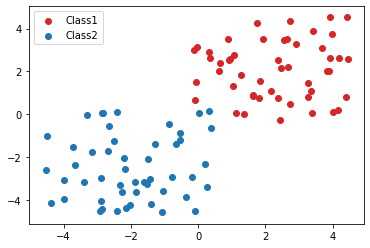

In [10]:
import matplotlib.pyplot as plt

colors = ("red", "blue")
groups = ("class 1", "class 2")

#plt.xlim(-r+1,r+1)
#plt.ylim(-r+1,r+1)
plt.scatter(data.Xdata1[:,0], data.Xdata1[:,1], color="tab:red", label= "Class1")
plt.scatter(data.Xdata2[:,0], data.Xdata2[:,1], color="tab:blue", label = "Class2")
plt.legend(loc = 'best')
plt.show()

In [23]:
from pennylane.templates.embeddings import AmplitudeEmbedding
from pennylane.templates.layers import RandomLayers
from pennylane.init import random_layers_normal

dev = qml.device('default.qubit', wires=2)

@qml.qnode(dev, interface = 'torch', cache=True)
def circuit(weights, p=None):
    AmplitudeEmbedding(p, wires=[0,1], pad=True, normalize=True)
        
    RandomLayers(weights, wires=[0,1], ratio_imprim=0.5, seed=2)
    return qml.expval(qml.PauliZ(0))


In [ ]:
def get_pred(weights, x):   #predictions for one batch
    pred = torch.empty(4,)
    
    for i in range(len(x)):
        qnode = qml.QNode(circuit, dev, cache=True)
        qnode = qnode.to_torch()
        pred[i] = qnode(weights, p=x[i])
    return pred

In [ ]:
def loss(weights, x, y):
    loss = 0
    pred = get_pred(weights,x)
    loss = torch.sum(torch.abs(pred-y)**2)/len(y)
    return loss

In [21]:
weights_init = random_layers_normal(n_layers=2, n_wires=2, seed=1)
print(weights_init)

[array([[ 0.16243454, -0.06117564],
       [-0.05281718, -0.10729686]])]


In [25]:
#from torch.autograd import Variable
#qnode = qml.QNode(circuit, dev, cache=True)
#qnode = qnode.to_torch()
test = torch.tensor([-2.4656, -0.1261],requires_grad=True)

print(test)
#test=test.numpy()
#print(test)
print(circuit(weights_init, p=test))

tensor([-2.4656, -0.1261], requires_grad=True)


TypeError: RY: Real scalar parameter expected, got <class 'numpy.ndarray'>.

In [ ]:
opt = torch.optim.Adam(weights, lr = 0.1)

steps = 100

def closure():
    opt.zero_grad()
    loss = loss(phi, theta)
    loss.backward()
    return loss

for i in range(steps):
    for d in data_batches:
        x,y = d
        opt.zero_grad()
        opt.step(closure)

In [ ]:
torch.empty(4,)

In [ ]:
import torch.nn.functional as F
opt = torch.optim.Adam(weights, lr = 0.1)

for steps in range(50):
    for d in data_batches:
        x,y = d
        opt.zero_grad()
        output = mynet(X.view(-1,28*28))
        loss = F.nll_loss(output,y)
        loss.backward()
        o.step()
    print(loss)